In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray

In [25]:
from mmctools.helper_functions import fit_power_law_alpha

In [3]:
from study import V27, neutral

# Estimate inflow from upstream plane
- velocity profile $= \bar{U}(t,z)$
- $\bar{U}$ is a 1-min rolling mean
- need offset in time from the x=-2.5D plane to the downstream wake planes

In [4]:
casedir = 'WAKEBENCH-NREL_DEBNATH_LES/neutral'
prefix = 'NREL_DEBNATH_LES_20190325'

In [5]:
case = neutral(casedir,prefix,turbine=V27)

In [6]:
-case.upstreamD*V27.D

67.5

## Load data into wake object

In [7]:
xa = xarray.open_dataset(case.get_wake_datafile(case.upstreamD))
xa

Selected datafile: WAKEBENCH-NREL_DEBNATH_LES/neutral/NREL_DEBNATH_LES_20190325_uvw_-2.5D.nc


<xarray.Dataset>
Dimensions:  (t: 1663, x: 1, y: 162, z: 162)
Coordinates:
  * t        (t) uint16 16150 16151 16152 16153 ... 17809 17810 17811 17812
  * x        (x) float64 -67.5
  * y        (y) float64 -40.0 -39.51 -39.01 -38.51 ... 38.51 39.01 39.51 40.0
  * z        (z) float64 0.4979 0.9949 1.492 1.989 ... 79.01 79.51 80.01 80.5
Data variables:
    U        (t, x, y, z) float64 ...
    V        (t, x, y, z) float64 ...
    W        (t, x, y, z) float64 ...

In [8]:
Ntimes = xa.dims['t']

In [9]:
t = xa.t.values
z = xa.z.values

In [10]:
xa.U

<xarray.DataArray 'U' (t: 1663, x: 1, y: 162, z: 162)>
[43643772 values with dtype=float64]
Coordinates:
  * t        (t) uint16 16150 16151 16152 16153 ... 17809 17810 17811 17812
  * x        (x) float64 -67.5
  * y        (y) float64 -40.0 -39.51 -39.01 -38.51 ... 38.51 39.01 39.51 40.0
  * z        (z) float64 0.4979 0.9949 1.492 1.989 ... 79.01 79.51 80.01 80.5
Attributes:
    long_name:  streamwise wind component
    units:      m/s

## Estimate TI

In [33]:
khub = np.argmin(np.abs(xa.coords['z'] - case.turbine.zhub))
print(khub, xa.coords['z'][khub])

<xarray.DataArray 'z' ()>
array(64) <xarray.DataArray 'z' ()>
array(32.3016)
Coordinates:
    z        float64 32.3


In [38]:
Uhub = xa.sel(dict(
    x=case.upstreamD*case.turbine.D,
    z=xa.coords['z'].values[khub]
)).to_dataframe()['U']

In [43]:
Ustd = Uhub.unstack().std().mean()
Ustd

0.8611093413128222

In [44]:
Ustd/case.Uref

0.09897808520837038

## Estimate profile

In [11]:
Uprofile_inst = xa.U.mean(dim=('x','y')) # average over x,y: U(t,z)

In [12]:
Uprofile_mean = Uprofile_inst.rolling(dim={'t':case.Navg}).mean()

In [13]:
Uprofile = Uprofile_inst.mean(dim='t') # average over t,x,y: U(z)

In [14]:
Uprofile_inst.shape, Uprofile_mean.shape, Uprofile.shape

((1663, 162), (1663, 162), (162,))

In [15]:
# profile envelope
Uprofile_min = Uprofile_inst.min(dim='t')
Uprofile_max = Uprofile_inst.max(dim='t')
Uprofile_std = Uprofile_inst.std(dim='t')

## Estimate simulated $\alpha$

In [27]:
alpha,R2 = fit_power_law_alpha(z,Uprofile,
                               zref=case.turbine.zhub,
                               Uref=case.Uref)

## Plot

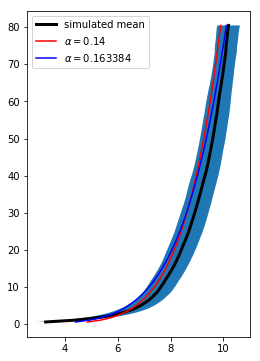

In [31]:
fig,ax = plt.subplots(figsize=(4,6))
ax.plot(Uprofile,z,'k',lw=3,label='simulated mean')
#ax.fill_betweenx(z, Uprofile_min, Uprofile_max)
ax.fill_betweenx(z, Uprofile-Uprofile_std, Uprofile+Uprofile_std)

U_powerlaw = case.Uref * (z/case.turbine.zhub)**case.alpha
ax.plot(U_powerlaw,z,'r',label=r'$\alpha = {:g}$'.format(case.alpha))

U_powerlaw = case.Uref * (z/case.turbine.zhub)**alpha
ax.plot(U_powerlaw,z,color='b',label=r'$\alpha = {:g}$'.format(alpha))

ax.legend()

## TKE profile

In [46]:
#df = xa.U.to_dataframe()

In [50]:
#df = df.xs(case.upstreamD*case.turbine.D,level='x')

In [56]:
#df.unstack(level=['y','z']).std().unstack(level='y')

y              -40.00    -39.51    -39.01    -38.51    -38.02    -37.52  \
  z                                                                       
U 0.497933   0.704174  0.682877  0.670210  0.681930  0.673164  0.674351   
  0.994865   0.772074  0.774546  0.781291  0.781885  0.795437  0.797494   
  1.491800   0.827235  0.947984  0.860644  0.949735  0.871584  0.982886   
  1.988730   0.917740  0.930286  0.958833  0.961363  0.974380  0.979197   
  2.485660   0.962926  1.026411  0.978186  1.045090  0.994247  1.051317   
  2.982600   1.031453  1.029889  1.031787  1.029113  1.037139  1.035739   
  3.479530   1.021020  1.081938  1.033761  1.071241  1.029337  1.075694   
  3.976460   1.035069  1.038468  1.050691  1.046001  1.048591  1.045448   
  4.473390   1.033729  1.064714  1.041568  1.069875  1.044740  1.065846   
  4.970330   1.046632  1.049389  1.053292  1.050420  1.054418  1.050515   
  5.467260   1.039783  1.070163  1.050527  1.071868  1.049438  1.076635   
  5.964190   1.047405  1.049309  1.057903  1.055449  1.060562  1.059194   
  6.461120   1.052939  1.076912  1.056699  1.080643  1.059570  1.082136   
  6.958060   1.070491  1.068455  1.068483  1.065758  1.068280  1.064384   
  7.454990   1.062154  1.090026  1.064823  1.084054  1.061024  1.083411   
  7.951920   1.066541  1.066391  1.070806  1.065032  1.066242  1.062143   
  8.448850   1.063713  1.091150  1.062589  1.085102  1.058990  1.080076   
  8.945790   1.071115  1.068942  1.065870  1.061621  1.060273  1.055383   
  9.442720   1.056873  1.073104  1.053399  1.065303  1.045865  1.062967   
  9.939650   1.050162  1.047222  1.047415  1.041498  1.040828  1.037588   
  10.436600  1.044097  1.059468  1.038805  1.044629  1.031177  1.045989   
  10.933500  1.045872  1.042719  1.039063  1.032196  1.029945  1.026313   
  11.430400  1.037483  1.053870  1.033353  1.040520  1.022647  1.034559   
  11.927400  1.036409  1.034508  1.033711  1.026891  1.023805  1.019331   
  12.424300  1.032226  1.048234  1.027344  1.036358  1.019003  1.031008   
  12.921200  1.034413  1.032395  1.028086  1.023276  1.020235  1.016536   
  13.418200  1.024354  1.038019  1.019704  1.027863  1.011766  1.024421   
  13.915100  1.019436  1.018167  1.016879  1.012136  1.009644  1.006557   
  14.412000  1.013161  1.026541  1.009107  1.016308  1.001910  1.012101   
  14.909000  1.013111  1.012148  1.007960  1.003669  1.000670  0.997832   
...               ...       ...       ...       ...       ...       ...   
  66.093000  0.658761  0.659186  0.660784  0.659211  0.660209  0.661802   
  66.590000  0.656898  0.663977  0.658135  0.659700  0.658050  0.665010   
  67.086900  0.656757  0.658554  0.658057  0.657379  0.657803  0.659355   
  67.583800  0.652766  0.663805  0.655360  0.659611  0.654632  0.662116   
  68.080800  0.651898  0.652691  0.654472  0.652873  0.653579  0.654709   
  68.577700  0.650166  0.657743  0.650810  0.652701  0.650202  0.656130   
  69.074600  0.650656  0.650877  0.649860  0.648725  0.649380  0.651109   
  69.571600  0.646625  0.655660  0.647089  0.649901  0.646565  0.655322   
  70.068500  0.646739  0.646393  0.647875  0.646437  0.647514  0.648830   
  70.565400  0.648207  0.655473  0.648855  0.651156  0.647859  0.653168   
  71.062300  0.653248  0.654405  0.654018  0.652236  0.651735  0.652583   
  71.559300  0.649936  0.666526  0.655939  0.661290  0.651540  0.660588   
  72.056200  0.650785  0.653176  0.659600  0.655699  0.654188  0.654703   
  72.553100  0.643831  0.659077  0.664163  0.661283  0.646713  0.657949   
  73.050100  0.639919  0.656002  0.658152  0.658468  0.642548  0.654894   
  73.547000  0.638987  0.654093  0.653997  0.656429  0.642738  0.654051   
  74.043900  0.640297  0.637813  0.637393  0.639567  0.643902  0.640561   
  74.540900  0.635614  0.640423  0.640544  0.643035  0.638282  0.640378   
  75.037800  0.633249  0.638288  0.638489  0.639927  0.634815  0.637343   
  75.534700  0.633212  0.637868  0.636924  0.638368  0.633678  0.636351   
  76.031700  0.635026  0.

In [ ]:
# ...

## save data
Values/nans for *rolling mean* `U_mean` of upstream sampled inflow for `Noffset==7`, `Navg==60`, and `Ntimes==1663`:
```
tidx  U(x=-2.5D)      U(x=0)
---  ---------------  -----------
0     nan             ???
7     nan             U_mean(t=0)==nan
59    U_mean(t=59)    U_mean(t=52)==nan
66    U_mean(t=66)    U_mean(t=59)
1655  U_mean(t=1655)  U_mean(t=1648)
1662  U_mean(t=1662)  U_mean(t=1655)
```
Therefore,
- upstream U(t,z) for t $\in$ [`Navg`-1, -`Noffset`]
- inflow U(t,z) for t $\in$ [`Navg`+`Noffset`-1, -1]

In [17]:
# number of planes before inflow hits the rotor
Noffset = int(-case.upstreamD*V27.D / case.Uref)
Noffset

7

In [18]:
case.Navg-1, Ntimes-Noffset-1

(59, 1655)

In [19]:
case.Navg+Noffset-1, Ntimes-1

(66, 1662)

In [20]:
inflow = Uprofile_mean.values

In [21]:
np.savez(os.path.join(casedir,'inflow.npz'), z=z, U=inflow)

DEBUG

In [22]:
# inflow
t[case.Navg-1:-Noffset]

array([16209, 16210, 16211, ..., 17803, 17804, 17805], dtype=uint16)

In [23]:
# wake plane
t[case.Navg+Noffset-1:]

array([16216, 16217, 16218, ..., 17810, 17811, 17812], dtype=uint16)

In [24]:
# wake plane
t[slice(case.Navg+Noffset-1,None)]

array([16216, 16217, 16218, ..., 17810, 17811, 17812], dtype=uint16)